In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20):
        data = np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/X_texture.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/y_texture.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys={}
        self.files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(self.files):
            self.keys[i]=name
        self.keys={14: 'wool', 23: 'jeans', 20: 'LacedMatt', 22: 'Gfoam', 27: 'bubble', 16: 'Efoam', 21: 'cotton', 11: 'Flat', 24: 'felt', 26: 'Ffoam'}
        print("Dataset size:",self.X.shape[0],"/nWindow size:",self.X.shape[1],"/nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"/nWindow size:",self.X.shape[1],"/nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        del self.X
        del self.y
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
data=loaded(t=5)
data.applySobel()
data.augment()



Dataset size: 4800 /nWindow size: 20 /nImage: (110, 120)
Memory needed: 1.18 GB
Dataset size: 14400 /nWindow size: 5 /nImage: (110, 120)
Memory needed: 0.89 GB


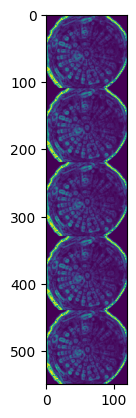

In [4]:
plt.imshow(data.AugmentedX[0].reshape((5*110,120)))
plt.show()

In [3]:
train_images_tensor = torch.tensor(data.AugmentedX.reshape((len(data.AugmentedX),1,5*110,120)), dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(data.Augmentedy.reshape(len(data.Augmentedy),1), dtype=torch.float32).to(device)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)


## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 137 * 30, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 137 * 30)  # Flatten the tensor 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train

In [5]:
# Define the Loss Function and Optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 50 == 0:  # Print every 100 batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

In [26]:
31564800/120/120/550

3.9854545454545454